In [1]:
import os
from os import path
import torch
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
exp_name = "RN50-SGD-CyclicLR-Classification-COCO-DA"
epochs = 120
batch_size = 64
num_batch_train = 200
num_batch_val = 80

In [3]:
parameters_path = path.join("parameters", exp_name)
plots_path = path.join("plots", exp_name)

In [4]:
import cv2
from albumentations import Compose, Normalize, VerticalFlip, HorizontalFlip, Rotate, Resize, LongestMaxSize, PadIfNeeded, BboxParams
from albumentations.pytorch import ToTensor
from torch.utils.data import Dataset
import json

def clamp(value, min_value, max_value):
    return max(min(value, max_value), min_value)

class CLASSIFICATION_DATASET(Dataset):
    def __init__(self,
                root_dirpath,
                images_dirpath,
                annotations_path,
                image_id_key="image_id",
                category_id_key="category_id",
                F_image_id_to_relative_path=None,
                augmentation=True,
                desired_size=280,
                batch_size=12,
                num_batch=1):

        self.root_dirpath = root_dirpath
        self.images_dirpath = images_dirpath
        self.annotations_path = annotations_path
        self.image_id_key=image_id_key
        self.category_id_key=category_id_key
        self.F_image_id_to_relative_path = F_image_id_to_relative_path
        self.augmentation = augmentation
        self.desired_size = desired_size
        self.batch_size = batch_size
        self.num_batch = num_batch

        with open(self.annotations_path) as f:
            self.D_instances = json.load(f)
            self.L_annotations = self.D_instances['annotations']
            self.L_categories = self.D_instances['categories']

        # list of real class indices in COCO dataset
        self.L_real_class_idx = [x['id'] for x in self.L_categories]
        # zero-based class indices of COCO dataset (0-79)
        self.L_class_idx = range(len(self.L_real_class_idx))
        # dict to map real class indices to zero-based indices
        self.D_real_class_idx_to_class_idx = { real_class_idx : class_idx for class_idx, real_class_idx in enumerate(self.L_real_class_idx)}

        # dict to map zero based indices to the relative annotations
        self.D_class_to_annotations = self.Create_class_to_annotations_dict()

        # filter zero-based class indices which have no annotations
        self.L_not_empty_class_idx = [class_idx for class_idx in self.L_class_idx if len(self.D_class_to_annotations[class_idx])>0]

        augmentation_transform = Compose(
            [
                VerticalFlip(p=0.5),
                HorizontalFlip(p=0.5),
                LongestMaxSize(max_size=desired_size),
                PadIfNeeded(min_height=desired_size, min_width=desired_size, border_mode=cv2.BORDER_CONSTANT),
                Rotate(p=1.0, limit=90, border_mode=cv2.BORDER_CONSTANT),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensor(),
            ])

        loading_transform = Compose(
            [
                LongestMaxSize(max_size=desired_size),
                PadIfNeeded(min_height=desired_size, min_width=desired_size, border_mode=cv2.BORDER_CONSTANT),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensor(),
            ])

        self.transform = augmentation_transform if self.augmentation else loading_transform

    def Create_class_to_annotations_dict(self):
        '''
        Create a dictionary of type (int : list) which map to each zero-based class index a list of
        all the COCO annotations of a specific class using self.D_real_class_idx_to_class_idx as map
        '''
        # init empty dictionary with zero-based class indices
        D_class_to_annotations = {idx : [] for idx in self.L_class_idx}

        for annotation in self.L_annotations:
            real_class_idx = annotation[self.category_id_key]
            class_idx = self.D_real_class_idx_to_class_idx[real_class_idx]
            D_class_to_annotations[class_idx].append(annotation)

        return D_class_to_annotations

    def Get_num_classes(self):
        return len(self.L_categories)

    def Get_class_idx_description(self, class_idx):
        return self.L_categories[class_idx]

    def __getitem__(self, index):
        try:
            # sample a random annotation from a random class
            item_class_idx = np.random.choice(self.L_not_empty_class_idx)
            D_item_annotation = np.random.choice(self.D_class_to_annotations[item_class_idx])

            item_image_id = D_item_annotation[self.image_id_key]

            if(self.F_image_id_to_relative_path):
                image_relative_path = self.F_image_id_to_relative_path(item_image_id)
            else:
                image_relative_path = item_image_id

            item_PIL_image = Image.open(path.join(self.images_dirpath, image_relative_path)).convert('RGB')
            image_width, image_height = item_PIL_image.size

            item_bbox = D_item_annotation['bbox']
            item_bbox[0] = clamp(item_bbox[0], 0, image_width)
            item_bbox[1] = clamp(item_bbox[1], 0, image_height)
            item_bbox[2] = clamp(item_bbox[2], 0, image_width-item_bbox[0])
            item_bbox[3] = clamp(item_bbox[3], 0, image_height-item_bbox[1])

            item_PIL_image_patch = item_PIL_image.crop((item_bbox[0], item_bbox[1], item_bbox[0]+item_bbox[2], item_bbox[1]+item_bbox[3]))
            D_item_transformed = self.transform(image=np.array(item_PIL_image_patch))
            return (D_item_transformed["image"],), item_class_idx
        except:
            return self[0]

    def __len__(self):
        return self.num_batch*self.batch_size

In [5]:
DSET_training = CLASSIFICATION_DATASET(
    root_dirpath = '../../../Datasets/COCO',
    images_dirpath = '../../../Datasets/COCO/train2017',
    annotations_path = '../../../Datasets/COCO/annotations/instances_train2017.json',
    F_image_id_to_relative_path = lambda image_id: "{:012d}.jpg".format(image_id),
    augmentation = True,
    batch_size = batch_size,
    num_batch = num_batch_train
)

In [6]:
DSET_validation = CLASSIFICATION_DATASET(
    root_dirpath = '../../../Datasets/COCO',
    images_dirpath = '../../../Datasets/COCO/val2017',
    annotations_path = '../../../Datasets/COCO/annotations/instances_val2017.json',
    F_image_id_to_relative_path = lambda image_id: "{:012d}.jpg".format(image_id),
    augmentation = False,
    batch_size = batch_size,
    num_batch = num_batch_val
)

In [7]:
class Denormalize_tensor(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

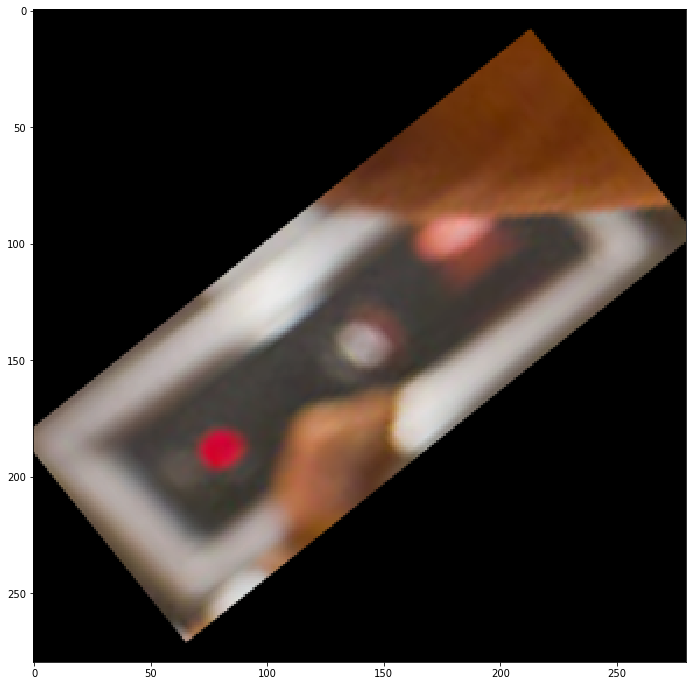

{'supercategory': 'appliance', 'id': 78, 'name': 'microwave'}

In [8]:
(T_img, ), class_idx = DSET_training[0]
denormalize_func = Denormalize_tensor(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
T_normal_img = denormalize_func(T_img)
plt.figure(figsize=(12, 12))
plt.imshow(transforms.ToPILImage()(T_normal_img))
plt.show()
DSET_training.Get_class_idx_description(class_idx)

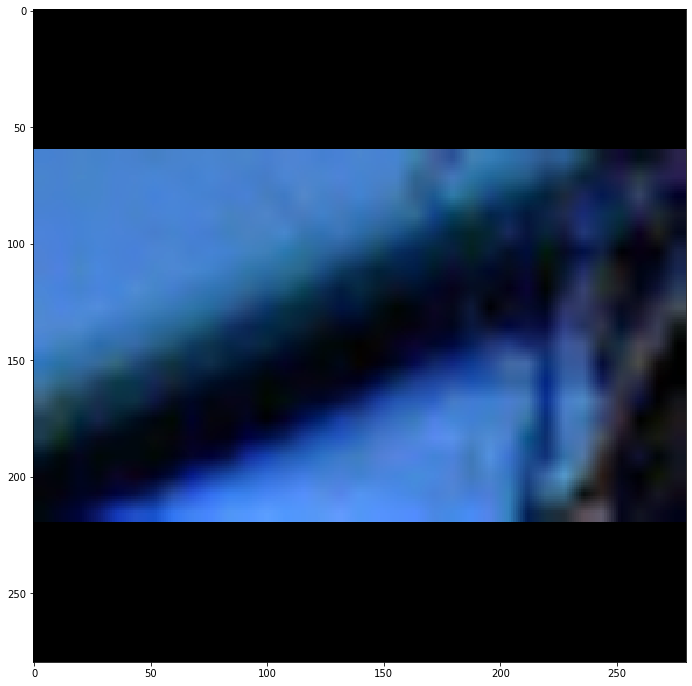

{'supercategory': 'indoor', 'id': 89, 'name': 'hair drier'}

In [9]:
(T_img, ), class_idx = DSET_validation[0]
denormalize_func = Denormalize_tensor(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
T_normal_img = denormalize_func(T_img)
plt.figure(figsize=(12, 12))
plt.imshow(transforms.ToPILImage()(T_normal_img))
plt.show()
DSET_validation.Get_class_idx_description(class_idx)

In [10]:
DL_training = DataLoader(DSET_training, batch_size=batch_size, shuffle=False)
DL_validation = DataLoader(DSET_validation, batch_size=batch_size, shuffle=False)

In [12]:
from torchvision.models import resnet50

class M_CLASSIFIER(torch.nn.Module):
    def __init__(self, num_classes):
        super(M_CLASSIFIER, self).__init__()
        self.num_classes = num_classes
        self.M_backbone = resnet50(pretrained=True)
        self.M_backbone.fc = torch.nn.Linear(
            in_features = 2048, 
            out_features = num_classes,
            bias=True
        )
        
    def forward(self, inputs):
        (T_image,) = inputs
        return self.M_backbone(T_image)
        
M_classifier = M_CLASSIFIER(DSET_training.Get_num_classes())
#M_classifier.load_state_dict(torch.load(path.join(parameters_path, "epoch-59.pth")))
M_classifier = M_classifier.to("cuda")

In [13]:
def prepare_batch_fn(batch, gt):
    gt = gt.long()
    return batch, gt

In [14]:
optimizer = torch.optim.SGD(M_classifier.parameters(), lr = 0.01, momentum = 0.2)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    step_size_up = 100,
    base_lr = 0.01, max_lr = 0.1,
    cycle_momentum=False,
    #base_momentum = 0.1, max_momentum = 0.3,
)

In [15]:
from torchtrainer.trainer import Trainer, Mode
from torchtrainer.callbacks.calculateaccuracycallback import CalculateTopNAccuracyCallback
from torchtrainer.callbacks.calculatelosscallback import CalculateLossCallback
from torchtrainer.callbacks.plotcallback import PlotCallback
from torchtrainer.callbacks.saveparameterscallback import SaveParametersCallback
from torchtrainer.callbacks.settqdmbardescription import SetTQDMBarDescription
from torchtrainer.callbacks.lrbatchschedulercallback import LRBatchSchedulerCallBack

In [16]:
trainer = Trainer(
    device = 'cuda',
    modes = [Mode.TRAIN, Mode.EVALUATE],
    model = M_classifier,
    data_loaders = {Mode.TRAIN : DL_training, Mode.EVALUATE : DL_validation},
    epochs = epochs,
    starting_epoch = 60,
    optimizer = optimizer,
    criterion = criterion,
    prepare_batch_fn = prepare_batch_fn,
    callbacks = [
        LRBatchSchedulerCallBack(scheduler),
        CalculateLossCallback(key='Loss'),
        CalculateTopNAccuracyCallback(keys=('Top-1 accuracy',), topk=(1,)),
        PlotCallback(plots_path, labels_map={Mode.TRAIN:"Train", Mode.EVALUATE:"Val"}, columns=['Loss', 'Top-1 accuracy']),
        SetTQDMBarDescription(keys=['Loss', 'Top-1 accuracy']),
        SaveParametersCallback(parameters_path),
    ]
)

In [ ]:
trainer.start()

Epoch 60


Loss = 1.1718 Top-1 accuracy = 67.6953 : 100%|██████████| 80/80 [01:45<00:00,  1.32s/it]

Epoch 61



Loss = 1.1434 Top-1 accuracy = 68.0078 : 100%|██████████| 80/80 [01:45<00:00,  1.32s/it]

Epoch 62



Loss = 1.1653 Top-1 accuracy = 68.4180 : 100%|██████████| 80/80 [01:45<00:00,  1.32s/it]

Epoch 63



Loss = 1.1756 Top-1 accuracy = 68.1641 : 100%|██████████| 80/80 [01:45<00:00,  1.32s/it]

Epoch 64



Loss = 1.1946 Top-1 accuracy = 67.6172 : 100%|██████████| 80/80 [01:45<00:00,  1.32s/it]

Epoch 65



Loss = 1.1719 Top-1 accuracy = 67.7734 : 100%|██████████| 80/80 [01:45<00:00,  1.32s/it]

Epoch 66



Loss = 1.1299 Top-1 accuracy = 68.7695 : 100%|██████████| 80/80 [01:45<00:00,  1.32s/it]

Epoch 67



Loss = 1.1735 Top-1 accuracy = 68.2227 : 100%|██████████| 80/80 [01:45<00:00,  1.31s/it]

Epoch 68



Loss = 1.1176 Top-1 accuracy = 69.3555 : 100%|██████████| 80/80 [01:45<00:00,  1.32s/it]

Epoch 69



Loss = 1.1019 Top-1 accuracy = 69.9609 : 100%|██████████| 80/80 [01:45<00:00,  1.32s/it]

Epoch 70



Loss = 1.1453 Top-1 accuracy = 69.0430 : 100%|██████████| 80/80 [01:45<00:00,  1.32s/it]

Epoch 71



Loss = 1.1691 Top-1 accuracy = 67.7344 : 100%|██████████| 80/80 [01:45<00:00,  1.32s/it]

Epoch 72



Loss = 1.1561 Top-1 accuracy = 68.9453 : 100%|██████████| 80/80 [01:45<00:00,  1.32s/it]

Epoch 73



Loss = 1.1557 Top-1 accuracy = 69.3359 : 100%|██████████| 80/80 [01:45<00:00,  1.32s/it]

Epoch 74



Loss = 1.0625 Top-1 accuracy = 69.5472 :  48%|████▊     | 97/200 [04:50<05:07,  2.99s/it]

In [12]:
from torch_lr_finder import LRFinder

  pip install torch-lr-finder -v --global-option="amp"


In [13]:
criterion = torch.nn.CrossEntropyLoss()


Learning rate search finished. See the graph with {finder_name}.plot()


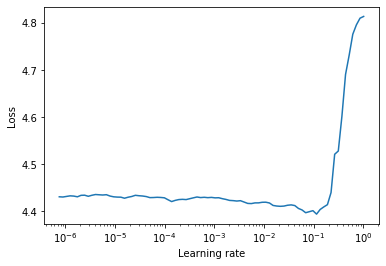

In [14]:
optimizer = torch.optim.SGD(M_classifier.parameters(), lr=1e-7, momentum=0.0)
lr_finder = LRFinder(M_classifier, optimizer, criterion, device="cuda")
lr_finder.range_test(DL_training, end_lr=2, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state


Learning rate search finished. See the graph with {finder_name}.plot()


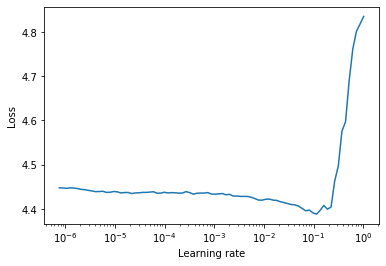

In [15]:
optimizer = torch.optim.SGD(M_classifier.parameters(), lr=1e-7, momentum=0.2)
lr_finder = LRFinder(M_classifier, optimizer, criterion, device="cuda")
lr_finder.range_test(DL_training, end_lr=2, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state


Learning rate search finished. See the graph with {finder_name}.plot()


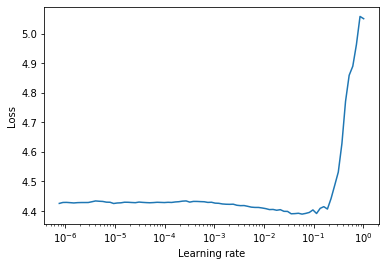

In [16]:
optimizer = torch.optim.SGD(M_classifier.parameters(), lr=1e-7, momentum=0.6)
lr_finder = LRFinder(M_classifier, optimizer, criterion, device="cuda")
lr_finder.range_test(DL_training, end_lr=2, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state